In [21]:
import numpy as np
import math
from typing import List, Tuple, Optional, Any
from abc import ABC, abstractmethod
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output, display


In [22]:
class State(ABC):
    """Abstract base class for game states"""

    @abstractmethod
    def get_actions(self) -> List[Any]:
        """Return list of valid actions from this state"""
        pass

    @abstractmethod
    def take_action(self, action: Any) -> 'State':
        """Return new state after taking action"""
        pass

    @abstractmethod
    def is_terminal(self) -> bool:
        """Check if this is a terminal state"""
        pass

    @abstractmethod
    def get_reward(self) -> float:
        """Get reward for terminal state"""
        pass

    @abstractmethod
    def get_current_player(self) -> int:
        """Get current player (for multi-player games)"""
        pass

In [23]:
class MCTSNode:
    """Node in the MCTS tree"""

    def __init__(self, state: State, parent: Optional['MCTSNode'] = None,
                 parent_action: Any = None):
        self.state = state
        self.parent = parent
        self.parent_action = parent_action
        self.children = {}  # action -> MCTSNode
        self.visits = 0
        self.value = 0.0
        # Only get actions if not terminal
        if not state.is_terminal():
            self.untried_actions = state.get_actions()
        else:
            self.untried_actions = []
        self.is_fully_expanded = len(self.untried_actions) == 0

    def ucb1(self, c: float = math.sqrt(2)) -> float:
        """Calculate UCB1 value for node selection"""
        if self.visits == 0:
            return float('inf')
        exploitation = self.value / self.visits
        exploration = c * math.sqrt(math.log(self.parent.visits) / self.visits)
        return exploitation + exploration

    def best_child(self, c: float = math.sqrt(2)) -> 'MCTSNode':
        """Select best child using UCB1"""
        return max(self.children.values(), key=lambda n: n.ucb1(c))

    def expand(self) -> 'MCTSNode':
        """Expand node by trying an untried action"""
        if not self.untried_actions:
            return self
        action = self.untried_actions.pop()
        next_state = self.state.take_action(action)
        child_node = MCTSNode(next_state, parent=self, parent_action=action)
        self.children[action] = child_node
        if len(self.untried_actions) == 0:
            self.is_fully_expanded = True
        return child_node

    def update(self, reward: float):
        """Update node statistics"""
        self.visits += 1
        self.value += reward

    def is_terminal(self) -> bool:
        """Check if node represents terminal state"""
        return self.state.is_terminal()

In [24]:
class MCTS_UCT:
    """Monte Carlo Tree Search with UCT (UCB applied to trees)"""

    def __init__(self, exploration_constant: float = math.sqrt(2),
                 time_limit: Optional[float] = None,
                 iteration_limit: Optional[int] = None,
                 rollout_policy: Optional[callable] = None,
                 verbose: bool = False):
        """
        Initialize MCTS-UCT algorithm

        Args:
            exploration_constant: C parameter for UCB1 formula
            time_limit: Time limit for search in seconds
            iteration_limit: Maximum number of iterations
            rollout_policy: Custom rollout policy (default: random)
            verbose: Print debug information
        """
        self.c = exploration_constant
        self.time_limit = time_limit
        self.iteration_limit = iteration_limit
        self.rollout_policy = rollout_policy or self.default_rollout
        self.root = None
        self.verbose = verbose

    def search(self, initial_state: State) -> Any:
        """
        Run MCTS-UCT search from initial state

        Returns:
            Best action to take from initial state
        """
        # Create root node
        self.root = MCTSNode(initial_state)

        # Set limits
        start_time = time.time()
        iterations = 0

        if self.verbose:
            print(f"Starting MCTS search with {self.iteration_limit} iterations...")

        # Main MCTS loop
        while self.should_continue(start_time, iterations):
            # Phase 1: Selection
            node = self.selection(self.root)

            # Phase 2: Expansion
            if not node.is_terminal() and not node.is_fully_expanded:
                node = node.expand()

            # Phase 3: Simulation (Rollout)
            reward = self.simulation(node)

            # Phase 4: Backpropagation
            self.backpropagation(node, reward)

            iterations += 1

            if self.verbose and iterations % 100 == 0:
                print(f"  Iteration {iterations}: Tree size = {self.get_tree_size()}")

        if self.verbose:
            print(f"Search complete. Total iterations: {iterations}")
            print(f"Tree size: {self.get_tree_size()} nodes")

        # Return best action from root
        return self.best_action(self.root)

    def selection(self, node: MCTSNode) -> MCTSNode:
        """
        Phase 1: Select leaf node using tree policy (UCB1)

        Traverse tree from root to leaf using UCB1 to select children
        """
        current = node

        while not current.is_terminal():
            if not current.is_fully_expanded:
                # Return node that can be expanded
                return current
            else:
                # Select best child using UCB1
                current = current.best_child(self.c)

        return current

    def simulation(self, node: MCTSNode) -> float:
        """
        Phase 3: Simulate game from leaf node using rollout policy

        Play out the game from current state to terminal state
        """
        current_state = node.state

        # Use rollout policy to simulate until terminal state
        while not current_state.is_terminal():
            action = self.rollout_policy(current_state)
            current_state = current_state.take_action(action)

        # Return reward from terminal state
        return current_state.get_reward()

    def backpropagation(self, node: MCTSNode, reward: float):
        """
        Phase 4: Backup - propagate reward up the tree

        Update statistics for all nodes in the path from leaf to root
        """
        current = node

        while current is not None:
            current.update(reward)
            current = current.parent

    def default_rollout(self, state: State) -> Any:
        """Default random rollout policy"""
        actions = state.get_actions()
        return random.choice(actions) if actions else None

    def should_continue(self, start_time: float, iterations: int) -> bool:
        """Check if search should continue based on limits"""
        if self.time_limit and (time.time() - start_time) >= self.time_limit:
            return False
        if self.iteration_limit and iterations >= self.iteration_limit:
            return False
        return True

    def best_action(self, node: MCTSNode) -> Any:
        """Select best action from root based on visit count"""
        if not node.children:
            return None

        # Choose action with highest visit count (most robust)
        best_action = max(node.children.keys(),
                         key=lambda a: node.children[a].visits)
        return best_action

    def get_action_values(self) -> dict:
        """Get values and visit counts for all actions from root"""
        if not self.root or not self.root.children:
            return {}

        action_values = {}
        for action, child in self.root.children.items():
            action_values[action] = {
                'visits': child.visits,
                'value': child.value / child.visits if child.visits > 0 else 0,
                'ucb1': child.ucb1(self.c)
            }
        return action_values

    def get_tree_size(self) -> int:
        """Get total number of nodes in the tree"""
        def count_nodes(node):
            if not node:
                return 0
            count = 1
            for child in node.children.values():
                count += count_nodes(child)
            return count

        return count_nodes(self.root)

In [25]:
class TicTacToeState(State):
    """Tic-Tac-Toe game state implementation"""

    def __init__(self, board: Optional[np.ndarray] = None, player: int = 1):
        self.board = board if board is not None else np.zeros((3, 3), dtype=int)
        self.player = player  # 1 or -1

    def get_actions(self) -> List[Tuple[int, int]]:
        """Get all empty positions"""
        # Simply return empty positions without checking terminal state
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def take_action(self, action: Tuple[int, int]) -> 'TicTacToeState':
        """Place piece at position"""
        new_board = self.board.copy()
        new_board[action[0], action[1]] = self.player
        return TicTacToeState(new_board, -self.player)

    def is_terminal(self) -> bool:
        """Check if game is over"""
        # Check for winner or board full (no empty positions)
        return self.check_winner() != 0 or not any(self.board[i, j] == 0
                                                    for i in range(3)
                                                    for j in range(3))

    def get_reward(self) -> float:
        """Get reward for terminal state (from perspective of player 1)"""
        winner = self.check_winner()
        if winner == 1:
            return 1.0
        elif winner == -1:
            return -1.0
        else:
            return 0.0

    def get_current_player(self) -> int:
        """Get current player"""
        return self.player

    def check_winner(self) -> int:
        """Check if there's a winner"""
        # Check rows
        for i in range(3):
            if abs(self.board[i].sum()) == 3:
                return self.board[i, 0]

        # Check columns
        for j in range(3):
            if abs(self.board[:, j].sum()) == 3:
                return self.board[0, j]

        # Check diagonals
        if abs(self.board.diagonal().sum()) == 3:
            return self.board[0, 0]
        if abs(np.fliplr(self.board).diagonal().sum()) == 3:
            return self.board[0, 2]

        return 0

    def __str__(self) -> str:
        """String representation of board"""
        symbols = {0: '.', 1: 'X', -1: 'O'}
        result = []
        for i in range(3):
            row = ' '.join(symbols[self.board[i, j]] for j in range(3))
            result.append(row)
        return '\n'.join(result)

    def display_pretty(self):
        """Display board with matplotlib"""
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)
        ax.set_aspect('equal')
        ax.axis('off')

        # Draw grid
        for i in range(4):
            ax.axhline(i, color='black', linewidth=2)
            ax.axvline(i, color='black', linewidth=2)

        # Draw pieces
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 1:  # X
                    ax.plot([j+0.2, j+0.8], [2.8-i, 2.2-i], 'b-', linewidth=3)
                    ax.plot([j+0.2, j+0.8], [2.2-i, 2.8-i], 'b-', linewidth=3)
                elif self.board[i, j] == -1:  # O
                    circle = patches.Circle((j+0.5, 2.5-i), 0.3, fill=False,
                                           edgecolor='red', linewidth=3)
                    ax.add_patch(circle)

        plt.title(f"Player {'X' if self.player == 1 else 'O'} to move")
        plt.show()

In [26]:
def interactive_demo():
    """Interactive MCTS-UCT demo on Tic-Tac-Toe"""
    print("=" * 50)
    print("MCTS-UCT Interactive Demo - Tic-Tac-Toe")
    print("=" * 50)

    # Initialize game
    state = TicTacToeState()

    # Configuration
    print("\nConfiguration:")
    iterations = 1000
    exploration = 1.4
    print(f"  • Iterations per move: {iterations}")
    print(f"  • Exploration constant: {exploration}")
    print(f"  • Both players use MCTS")
    print()

    move_count = 0

    while not state.is_terminal():
        move_count += 1
        player_symbol = 'X' if state.player == 1 else 'O'

        print(f"\n{'='*30}")
        print(f"Move {move_count} - Player {player_symbol}")
        print(f"{'='*30}")
        print(f"Current board:\n{state}\n")

        # Run MCTS to find best action
        mcts = MCTS_UCT(
            exploration_constant=exploration,
            iteration_limit=iterations,
            verbose=False
        )

        action = mcts.search(state)

        if action:
            # Show action statistics
            action_values = mcts.get_action_values()

            print(f"Action Analysis:")
            # Sort actions by visits for better display
            sorted_actions = sorted(action_values.items(),
                                  key=lambda x: x[1]['visits'],
                                  reverse=True)

            for act, stats in sorted_actions[:5]:  # Show top 5 actions
                print(f"  Position {act}: Visits={stats['visits']:4d}, "
                      f"Value={stats['value']:6.3f}, UCB1={stats['ucb1']:.3f}")

            print(f"\n➜ Selected action: {action}")
            print(f"  (Most visited: {action_values[action]['visits']} visits)")

            # Take action
            state = state.take_action(action)
        else:
            print("No valid actions available")
            break

        # Small delay for readability
        time.sleep(0.1)

    # Game over
    print("\n" + "=" * 50)
    print("GAME OVER!")
    print("=" * 50)
    print(f"Final board:\n{state}\n")

    winner = state.check_winner()
    if winner == 1:
        print("🏆 Winner: X")
    elif winner == -1:
        print("🏆 Winner: O")
    else:
        print("🤝 Draw!")

    return state


In [27]:
def visualize_tree_sample(mcts: MCTS_UCT, max_depth: int = 3):
    """Visualize a sample of the MCTS tree structure"""

    def draw_node(ax, node, x, y, width, depth):
        if depth > max_depth or not node:
            return

        # Draw node
        circle = patches.Circle((x, y), 0.1, color='lightgray', ec='black')
        ax.add_patch(circle)
        ax.text(x, y, f"{node.visits}", ha='center', va='center', fontsize=8)

        # Draw children
        if node.children:
            child_width = width / len(node.children)
            child_x = x - width/2 + child_width/2

            for action, child in node.children.items():
                # Draw edge
                ax.plot([x, child_x], [y, y-1], 'k-', alpha=0.3)
                ax.text((x+child_x)/2, y-0.5, f"{action}", fontsize=6)

                # Recursively draw child
                draw_node(ax, child, child_x, y-1, child_width, depth+1)
                child_x += child_width

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-max_depth-1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    # Draw tree starting from root
    if mcts.root:
        draw_node(ax, mcts.root, 0, 0, 8, 0)

    plt.title("MCTS Tree Sample (showing visit counts)")
    plt.tight_layout()
    plt.show()

def plot_action_statistics(action_values: dict):
    """Plot statistics for all actions"""
    if not action_values:
        print("No actions to plot")
        return

    actions = list(action_values.keys())
    visits = [action_values[a]['visits'] for a in actions]
    values = [action_values[a]['value'] for a in actions]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot visits
    ax1.bar(range(len(actions)), visits)
    ax1.set_xlabel('Action')
    ax1.set_ylabel('Visit Count')
    ax1.set_title('Action Visit Counts')
    ax1.set_xticks(range(len(actions)))
    ax1.set_xticklabels([str(a) for a in actions], rotation=45)

    # Plot values
    ax2.bar(range(len(actions)), values)
    ax2.set_xlabel('Action')
    ax2.set_ylabel('Average Value')
    ax2.set_title('Action Values')
    ax2.set_xticks(range(len(actions)))
    ax2.set_xticklabels([str(a) for a in actions], rotation=45)

    plt.tight_layout()
    plt.show()


In [28]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Running basic MCTS-UCT demo...\n")

# Create initial state
initial_state = TicTacToeState()
print("Initial board:")
print(initial_state)

# Run MCTS
mcts = MCTS_UCT(
    exploration_constant=math.sqrt(2),
    iteration_limit=1000,
    verbose=True
)

best_action = mcts.search(initial_state)
print(f"\nBest action found: {best_action}")

# Show statistics
action_stats = mcts.get_action_values()
print("\nAction statistics:")
for action, stats in action_stats.items():
    print(f"  {action}: visits={stats['visits']}, value={stats['value']:.3f}")

Running basic MCTS-UCT demo...

Initial board:
. . .
. . .
. . .
Starting MCTS search with 1000 iterations...
  Iteration 100: Tree size = 101
  Iteration 200: Tree size = 201
  Iteration 300: Tree size = 301
  Iteration 400: Tree size = 401
  Iteration 500: Tree size = 501
  Iteration 600: Tree size = 601
  Iteration 700: Tree size = 701
  Iteration 800: Tree size = 801
  Iteration 900: Tree size = 901
  Iteration 1000: Tree size = 1001
Search complete. Total iterations: 1000
Tree size: 1001 nodes

Best action found: (1, 1)

Action statistics:
  (2, 2): visits=65, value=0.262
  (2, 1): visits=36, value=0.111
  (2, 0): visits=98, value=0.367
  (1, 2): visits=35, value=0.114
  (1, 1): visits=438, value=0.566
  (1, 0): visits=43, value=0.163
  (0, 2): visits=139, value=0.424
  (0, 1): visits=10, value=-0.500
  (0, 0): visits=136, value=0.426


In [29]:
print("\n" + "="*50)
print("Starting Interactive Game Demo")
print("="*50)

# Run the interactive demo
final_state = interactive_demo()


Starting Interactive Game Demo
MCTS-UCT Interactive Demo - Tic-Tac-Toe

Configuration:
  • Iterations per move: 1000
  • Exploration constant: 1.4
  • Both players use MCTS


Move 1 - Player X
Current board:
. . .
. . .
. . .

Action Analysis:
  Position (1, 1): Visits= 476, Value= 0.609, UCB1=0.778
  Position (2, 2): Visits= 112, Value= 0.429, UCB1=0.776
  Position (0, 2): Visits=  89, Value= 0.382, UCB1=0.772
  Position (0, 0): Visits=  63, Value= 0.302, UCB1=0.765
  Position (2, 1): Visits=  59, Value= 0.288, UCB1=0.767

➜ Selected action: (1, 1)
  (Most visited: 476 visits)

Move 2 - Player O
Current board:
. . .
. X .
. . .

Action Analysis:
  Position (1, 0): Visits= 320, Value= 0.719, UCB1=0.924
  Position (2, 1): Visits= 229, Value= 0.677, UCB1=0.920
  Position (1, 2): Visits= 112, Value= 0.562, UCB1=0.910
  Position (0, 1): Visits= 107, Value= 0.561, UCB1=0.916
  Position (0, 2): Visits=  71, Value= 0.465, UCB1=0.901

➜ Selected action: (1, 0)
  (Most visited: 320 visits)

Mo

Performance Analysis

Testing different configurations...
  Iterations= 100, C=0.50: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 100, C=1.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 100, C=1.41: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 100, C=2.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 500, C=0.50: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 500, C=1.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 500, C=1.41: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations= 500, C=2.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=1000, C=0.50: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=1000, C=1.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=1000, C=1.41: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=1000, C=2.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=2000, C=0.50: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=2000, C=1.00: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=2000, C=1.41: {'X': 10, 'O': 0, 'Draw': 0}
  Iterations=2000, C=2.00: {'X': 10, 'O': 0, 'Draw': 0}


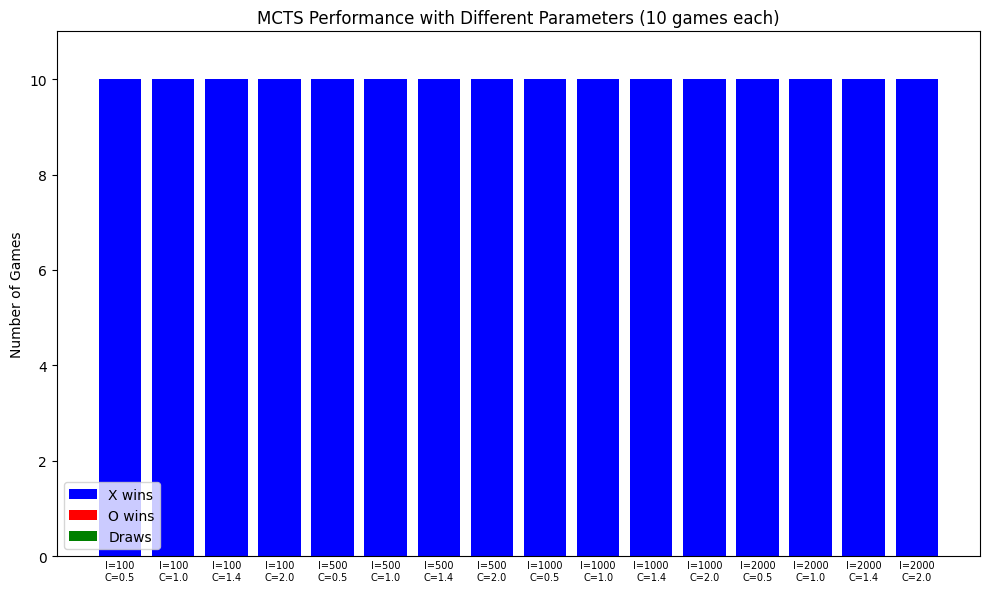

In [32]:
def performance_analysis():
    """Analyze MCTS performance with different parameters"""

    print("=" * 50)
    print("Performance Analysis")
    print("=" * 50)

    # Test different iteration counts
    iteration_counts = [100, 500, 1000, 2000]
    exploration_constants = [0.5, 1.0, math.sqrt(2), 2.0]

    results = {}

    print("\nTesting different configurations...")

    for iterations in iteration_counts:
        for exploration in exploration_constants:
            # Run multiple games
            wins = {'X': 0, 'O': 0, 'Draw': 0}

            for _ in range(10):  # Run 10 games for each configuration
                state = TicTacToeState()

                while not state.is_terminal():
                    mcts = MCTS_UCT(
                        exploration_constant=exploration,
                        iteration_limit=iterations,
                        verbose=False
                    )
                    action = mcts.search(state)
                    if action:
                        state = state.take_action(action)

                winner = state.check_winner()
                if winner == 1:
                    wins['X'] += 1
                elif winner == -1:
                    wins['O'] += 1
                else:
                    wins['Draw'] += 1

            results[(iterations, exploration)] = wins
            print(f"  Iterations={iterations:4d}, C={exploration:.2f}: {wins}")

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))

    x_pos = 0
    colors = ['blue', 'red', 'green']
    labels = ['X wins', 'O wins', 'Draws']

    for iterations in iteration_counts:
        for i, exploration in enumerate(exploration_constants):
            wins = results[(iterations, exploration)]
            bottom = 0
            for j, (key, color) in enumerate(zip(['X', 'O', 'Draw'], colors)):
                ax.bar(x_pos, wins[key], bottom=bottom, color=color, width=0.8,
                      label=labels[j] if x_pos == 0 else "")
                bottom += wins[key]

            ax.text(x_pos, -0.5, f"I={iterations}\nC={exploration:.1f}",
                   ha='center', fontsize=7)
            x_pos += 1

    ax.set_ylabel('Number of Games')
    ax.set_title('MCTS Performance with Different Parameters (10 games each)')
    ax.set_xticks([])
    ax.legend()
    ax.set_ylim(0, 11)

    plt.tight_layout()
    plt.show()

# Actually run the function!
performance_analysis()